In [1]:
# Script to compute phase and amplitude from the simulation results. The code also plots the results.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

S5k12 = pd.read_csv('S5/k12/S5k12.csv',header=None)
S6k12 = pd.read_csv('S6/k12/S6k12.csv',header=None)
S7k12 = pd.read_csv('S7/k12/S7k12.csv',header=None)

S5k10 = pd.read_csv('S5/k10/S5k10.csv',header=None)
S6k10 = pd.read_csv('S6/k10/S6k10.csv',header=None)
S7k10 = pd.read_csv('S7/k10/S7k10.csv',header=None)

S5k11 = pd.read_csv('S5/k11/S5k11.csv',header=None)
S6k11 = pd.read_csv('S6/k11/S6k11.csv',header=None)
S7k11 = pd.read_csv('S7/k11/S7k11.csv',header=None)

#S5k10_w = pd.read_csv('/home/jose/MEGA/PhD/Paper_2/RZ/hydraulic_hetero/Paper_files/S5/k10/S5k10_wang.csv',header=None)

P_LE_a = np.logspace(-7,-4,8)
P_LE_w = np.logspace(-7,-4,20)
P_LE_a = np.logspace(-7, -4, 7)

In [28]:
# First poroelastic functions are computed to set values for the analytical solution

# These values are assumed by me

a = 1 # Biot modulus
Kf = 2.0E09 # Bulk modulus water
phi = 0.2 # Porosity
nu = .25 # Poissons ratio
K = 1E10 # Drained bulk modulus

def Skempton_coefficient(a, Kf, phi, K):
    params = (a*Kf)/((a-phi*(1-a))*Kf + phi*K)
    return params

def Biot_modulus(phi, Kf, K):
    params = (phi / Kf) + ((1 - a) * (a - phi)) / (K)
    return params
    
def Undrained_bulk_modulus(K, a, M):
    params = K + (a**2) * M
    return params

def shear_modulus(K, nu):
    params = (3 * K * (1 - 2 * nu)) / (2 * (1 + nu))
    return params

def Undrained_Poisson(Ku, G):
    params = (3 * Ku - 2 * G) / (2 * (3 * Ku + G))
    return params

def Barometric_efficiency(B, nu_u):
    params = B * (1+nu_u)/(3*(1-nu_u))
    return params

def Barometric_efficiency_2D(B, nu_u):
    params = 2* B * (1+nu_u)/3
    return params

B = Skempton_coefficient(a, Kf, phi, K)
M = 1 / Biot_modulus(phi, Kf, K)
Ku = Undrained_bulk_modulus(K, a, M)
G = shear_modulus(K, nu)
nu_u = Undrained_Poisson(Ku, G)
y = Barometric_efficiency(B, nu_u)

In [29]:
from scipy.special import kv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

###
# Phython script to that solves for the analytical solution of Wang found in this paper.
# Wang, C. Y., Doan, M. L., Xue, L., & Barbour, A. J. (2018). Tidal response of groundwater in a leaky aquifer—Application to Oklahoma. Water Resources Research, 54(10), 8019-8033.

# This code plots the figure found in the paper to validate the analytical solution
# Conductivity range -9 to -2 m/s
# No leaky layer
# Speacific storage 0.01 1/m

# This solution is the same as Hsieh when no leakage is set!
###

# Variables
R_W = 0.2 # well radius m
R_C = 0.2 # well case m
R = 0.2 # distance from the well m (only for drawdown computation)

PERIOD = 1 * 24 * 3600 / 2 # s

P_LE = np.logspace(-7,-4, 29)

K_AQ = np.array([1E-3, 1E-4, 1E-5]) # HC bottom m/s
K_LE = P_LE # HC top m/s NO LEAKAGE!
K_LE2 = 0.1*P_LE * 1E7

B_AQ = 1 # Aquifer depth m
B_LE = 100 # Leaky layer depth m

S_AQ = np.array([1E-5, 1E-6, 1E-7]) * 101 #1E-4 # Specific storage []

SKEMPTON = B # Skempton's coefficient [-]
BULK = Ku # Undrained bulk modulus [Pa] (computed in the above cell)

E_0 = 1E-7 # Signal amplitude [-] (this amplitude is unrealistic, but convinient for this example)

# Functions
def omega_fn(PERIOD):
    params = 2 * np.pi / PERIOD
    return params

def betta_fn(K_LE, K_AQ, B_AQ, B_LE, omega, S_AQ):
    params = ((K_LE / (K_AQ * B_AQ * B_LE)) + ((1j * omega * S_AQ * B_AQ) / (K_AQ * B_AQ))) ** 0.5
    return params

def argument_fn(omega, S_AQ, B_AQ, K_LE, B_LE):
    params = (1j * omega * S_AQ * B_AQ) / (1j * omega * S_AQ * B_AQ + K_LE / B_LE)
    return params

def tide_fn(SKEMPTON, BULK, E_0):
    params = (SKEMPTON * BULK * E_0) / 1E4
    return params

def xi_fn(R_W, R_C, omega, K_AQ, B_AQ, betta):
    params = 1 + ((1j * omega * R_W) / (2 * K_AQ * B_AQ * betta)) * (kv(0, betta * R_W) / kv(1, betta * R_W)) * (R_C / R_W)**2
    return params

def h_w_fn(argument, tide, xi):
    params = argument * tide / xi
    return params

def drawdown_fn(omega, R_C, h_w, betta, K_AQ, B_AQ, R):
    params = -(1j * omega * R_C ** 2 * h_w * kv(0, betta * R)) / (2 * K_AQ * B_AQ * betta * R_W * kv(1, betta * R))
    return params

def flux_fn(omega, h_w,  R_C):
    params = omega * np.absolute(h_w) * np.pi * R_C**2 *1E3
    return params

# Empty array to save solutions
h_w = np.zeros((len(S_AQ), len(K_LE)), dtype = 'complex_') # Well drawdown
drawdown = np.zeros_like(h_w) # Aquifer drawdwon
flux = np.zeros((len(S_AQ), len(K_LE))) # Well flux amplitude

amplitudes = ['A_10', 'A_11', 'A_12']
shifhts = ['phi_10', 'phi_11', 'phi_12']
d = {}

for j,k in enumerate(amplitudes):
    A_10 = np.zeros_like(h_w) # Amplitude ratio
    phi_10 = np.zeros_like(h_w) # Time shift
    for i, p in enumerate(S_AQ):

        # Over the functions
        omega = omega_fn(PERIOD)
        betta = betta_fn(K_LE, K_AQ[j], B_AQ, B_LE, omega, p)
        argument = argument_fn(omega, p, B_AQ, K_LE, B_LE)
        tide = tide_fn(SKEMPTON, BULK, E_0)
        xi = xi_fn(R_W, R_C, omega, K_AQ[j], B_AQ, betta)

        # Save solutions in arrays
        h_w[i,:] = h_w_fn(argument, tide, xi)
        drawdown[i,:] = np.absolute(drawdown_fn(omega, R_C, h_w[i,:], betta, K_AQ[j], B_AQ, R))
        A_10[i,:] = np.absolute(h_w[i,:] / tide)
        phi_10[i,:] = np.angle(h_w[i,:] / tide, deg=True)
        flux[i,:] = (flux_fn(omega, h_w[i,:],  R_C))
        
    d[amplitudes[j]] = A_10
    d[shifhts[j]] = phi_10
        
        


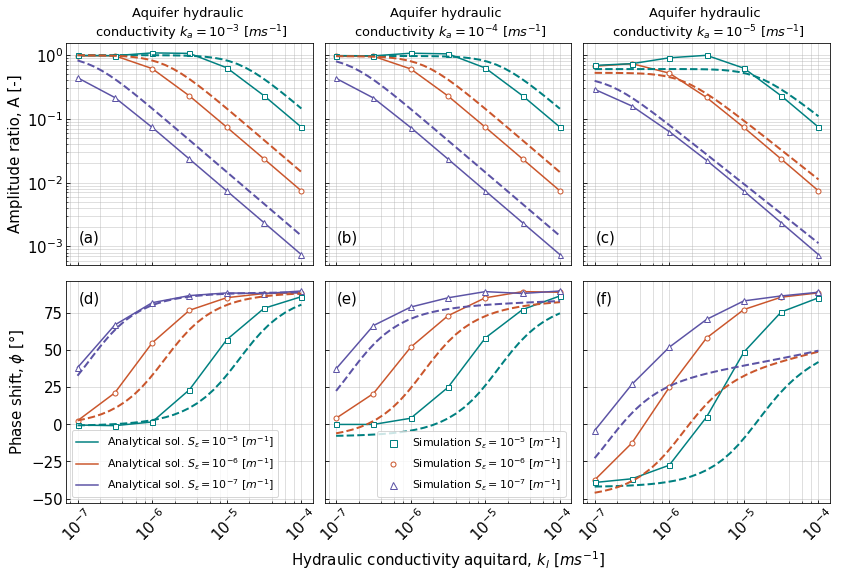

In [31]:
plt.rcParams.update({'font.size': 15})
alpha=1
fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize = (12,8), sharex=True, sharey='row')


ax1.set_title('Aquifer hydraulic \n conductivity $k_{a} = 10^{-3}$ $[ms^{-1}]$', fontsize = 13)
ax2.set_title('Aquifer hydraulic \n conductivity $k_{a} = 10^{-4}$ $[ms^{-1}]$', fontsize = 13)
ax3.set_title('Aquifer hydraulic \n conductivity $k_{a} = 10^{-5}$ $[ms^{-1}]$', fontsize = 13)

ax1.xaxis.set_tick_params(direction='in', which='both')
ax1.yaxis.set_tick_params(direction='in', which='both')
ax2.xaxis.set_tick_params(direction='in', which='both')
ax2.yaxis.set_tick_params(direction='in', which='both')
ax3.xaxis.set_tick_params(direction='in', which='both')
ax3.yaxis.set_tick_params(direction='in', which='both')

ax4.xaxis.set_tick_params(direction='in', which='both')
ax4.yaxis.set_tick_params(direction='in', which='both')
ax5.xaxis.set_tick_params(direction='in', which='both')
ax5.yaxis.set_tick_params(direction='in', which='both')
ax6.xaxis.set_tick_params(direction='in', which='both')
ax6.yaxis.set_tick_params(direction='in', which='both')


ax1.plot(P_LE_a, S6k10.iloc[:, 0], '-o', color = '#ca562c', markersize=5, markerfacecolor='w')
ax3.plot(P_LE_a, S6k12.iloc[:, 0], '-o', color = '#ca562c', markersize=5, markerfacecolor='w')
ax2.plot(P_LE_a, S6k11.iloc[:, 0], '-o', color = '#ca562c', markersize=5, markerfacecolor='w')

ax1.plot(P_LE_a, S5k10.iloc[:, 0], '-s', color = '#008080', markersize=5, alpha = alpha, markerfacecolor='w')
ax3.plot(P_LE_a, S5k12.iloc[:, 0], '-s', color = '#008080', markersize=5, alpha = alpha, markerfacecolor='w')
ax2.plot(P_LE_a, S5k11.iloc[:, 0], '-s', color = '#008080', markersize=5, alpha = alpha, markerfacecolor='w')

ax1.plot(P_LE_a, S7k10.iloc[:, 0], '-^', color = '#5c53a5', markersize=6, alpha = alpha, markerfacecolor='w')
ax3.plot(P_LE_a, S7k12.iloc[:, 0], '-^', color = '#5c53a5', markersize=5, alpha = alpha, markerfacecolor='w')
ax2.plot(P_LE_a, S7k11.iloc[:, 0], '-^', color = '#5c53a5', markersize=5, alpha = alpha, markerfacecolor='w')


ax4.plot(P_LE_a, S6k10.iloc[:, 1], '-o', color = '#ca562c', markersize=5, markerfacecolor='w')
ax6.plot(P_LE_a, S6k12.iloc[:, 1], '-o', color = '#ca562c', markersize=5, markerfacecolor='w')
ax5.plot(P_LE_a, S6k11.iloc[:, 1], '-o', color = '#ca562c', markersize=5, markerfacecolor='w')

ax4.plot(P_LE_a, S5k10.iloc[:, 1], '-s', color = '#008080', markersize=5, markerfacecolor='w')
ax6.plot(P_LE_a, S5k12.iloc[:, 1], '-s', color = '#008080', markersize=5, markerfacecolor='w')
ax5.plot(P_LE_a, S5k11.iloc[:, 1], '-s', color = '#008080', markersize=5, markerfacecolor='w')

ax4.plot(P_LE_a, S7k10.iloc[:, 1], '-^', color = '#5c53a5', markersize=6, alpha = alpha, markerfacecolor='w')
ax6.plot(P_LE_a, S7k12.iloc[:, 1], '-^', color = '#5c53a5', markersize=6, alpha = alpha, markerfacecolor='w')
ax5.plot(P_LE_a, S7k11.iloc[:, 1], '-^', color = '#5c53a5', markersize=6, alpha = alpha, markerfacecolor='w')


K_LE = P_LE
ax1.plot(K_LE, np.real(d['A_10'][0,:]),'--', color = '#008080',linewidth = 2)
ax1.plot(K_LE, np.real(d['A_10'][1,:]),'--',color = '#ca562c',linewidth = 2)
ax1.plot(K_LE, np.real(d['A_10'][2,:]),'--',color = '#5c53a5',linewidth = 2)

ax2.plot(K_LE, np.real(d['A_11'][0,:]),'--', color = '#008080',linewidth = 2)
ax2.plot(K_LE, np.real(d['A_11'][1,:]),'--',color = '#ca562c',linewidth = 2)
ax2.plot(K_LE, np.real(d['A_11'][2,:]),'--',color = '#5c53a5',linewidth = 2)

ax3.plot(K_LE, np.real(d['A_12'][0,:]),'--', color = '#008080',linewidth = 2)
ax3.plot(K_LE, np.real(d['A_12'][1,:]),'--',color = '#ca562c',linewidth = 2)
ax3.plot(K_LE, np.real(d['A_12'][2,:]),'--',color = '#5c53a5',linewidth = 2)

ax4.plot(K_LE, np.real(d['phi_10'][0,:]),'--', color = '#008080',linewidth = 2)
ax4.plot(K_LE, np.real(d['phi_10'][1,:]),'--',color = '#ca562c',linewidth = 2)
ax4.plot(K_LE, np.real(d['phi_10'][2,:]),'--',color = '#5c53a5',linewidth = 2)

ax5.plot(K_LE, np.real(d['phi_11'][0,:]),'--', color = '#008080',linewidth = 2)
ax5.plot(K_LE, np.real(d['phi_11'][1,:]),'--',color = '#ca562c',linewidth = 2)
ax5.plot(K_LE, np.real(d['phi_11'][2,:]),'--',color = '#5c53a5',linewidth = 2)

ax6.plot(K_LE, np.real(d['phi_12'][0,:]),'--', color = '#008080',linewidth = 2)
ax6.plot(K_LE, np.real(d['phi_12'][1,:]),'--',color = '#ca562c',linewidth = 2)
ax6.plot(K_LE, np.real(d['phi_12'][2,:]),'--',color = '#5c53a5',linewidth = 2)


ax1.set_xscale('log')
ax2.set_xscale('log')
ax3.set_xscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')

ax4.set_xscale('log')
ax5.set_xscale('log')
ax6.set_xscale('log')

#ax3.set_xlabel('Hydraulic conductivity $k$ $[m/s]$')
ax1.set_ylabel('Amplitude ratio, A [-]')
ax4.set_ylabel('Phase shift, $\phi$ $[°]$')

#ax4.set_xlabel('Permeability leaky layer $k_{t}$ $[m/s]$')
ax5.set_xlabel('Hydraulic conductivity aquitard, $k_{l}$ $[ms^{-1}]$')
#ax6.set_xlabel('Permeability leaky layer $k_{t}$ $[m/s]$')

ax4.plot([], [], '-', label='Analytical sol. $S_{\epsilon} = 10^{-5}$ $[m^{-1}]$',color = '#008080', markerfacecolor='w')
ax4.plot([], [], '-', label='Analytical sol. $S_{\epsilon} = 10^{-6}$ $[m^{-1}]$',color = '#ca562c', markerfacecolor='w')
ax4.plot([], [], '-', label='Analytical sol. $S_{\epsilon} = 10^{-7}$ $[m^{-1}]$',color = '#5c53a5', markerfacecolor='w')

ax5.plot([], [], 's', label='Simulation $S_{\epsilon} = 10^{-5}$ $[m^{-1}]$',color = '#008080', markerfacecolor='w', markersize=7)
ax5.plot([], [], 'o', label='Simulation $S_{\epsilon} = 10^{-6}$ $[m^{-1}]$',color = '#ca562c', markerfacecolor='w', markersize=5)
ax5.plot([], [], '^', label='Simulation $S_{\epsilon} = 10^{-7}$ $[m^{-1}]$',color = '#5c53a5', markerfacecolor='w', markersize=7)
ax4.legend(ncol=1, fontsize = 11, columnspacing = 0.5)
ax5.legend(ncol=1, fontsize = 11, columnspacing = 0.5)

fig.tight_layout()


import matplotlib.ticker
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax1.xaxis.set_minor_locator(locmin)
ax2.xaxis.set_minor_locator(locmin)
ax3.xaxis.set_minor_locator(locmin)

ax1.grid(which='both', alpha = 0.5)
ax2.grid(which='both', alpha = 0.5)
ax3.grid(which='both', alpha = 0.5)

ax4.grid(which='both', alpha = 0.5)
ax5.grid(which='both', alpha = 0.5)
ax6.grid(which='both', alpha = 0.5)

fig.subplots_adjust(wspace=0.05)


ax1.annotate('(a)', xy=(0.05, 0.1), xycoords='axes fraction')
ax2.annotate('(b)', xy=(0.05, 0.1), xycoords='axes fraction')
ax3.annotate('(c)', xy=(0.05, 0.1), xycoords='axes fraction')
ax4.annotate('(d)', xy=(0.05, 0.9), xycoords='axes fraction')
ax5.annotate('(e)', xy=(0.05, 0.9), xycoords='axes fraction')
ax6.annotate('(f)', xy=(0.05, 0.9), xycoords='axes fraction')

ax4.tick_params(labelrotation=45)
ax5.tick_params(labelrotation=45)
ax6.tick_params(labelrotation=45)
for tick in ax4.get_yticklabels():
    tick.set_rotation(0)


fig.savefig('Figure_7.pdf', bbox_inches='tight')

